In [133]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")


In [134]:
loan = pd.read_csv('Loans.csv')
borrower = pd.read_csv('Borrowers.csv')
repayment = pd.read_csv('Repayments.csv')

### SQL Queries

a. The total number of loans issued.

SELECT COUNT(DISTINCT loan_id)  
FROM loans

b. The average loan amount

SELECT AVG(loan_amount) AS average_loan_amount  
FROM loans

c. The number of loans issued per month

SELECT DATE_FORMAT(date_issued, '%Y-%m') AS month, COUNT(DISTINCT loan_id) AS loans_issued  
FROM loans  
GROUP BY DATE_FORMAT(date_issued, '%Y-%m')  
ORDER BY month;  

d. The total amount repaid

SELECT SUM(amount_repaid) AS total_amount_repaid  
FROM repayment;


In [135]:
loan

,loan_id,borrower_id,loan_amount,interest_rate,term_months,status,date_issued,date_due,date_repaid
0,1,101,5000,5.0,12,approved,2023-01-01,2023-01-31,NaN
1,2,102,8000,6.5,24,repaid,2023-02-01,2023-02-28,2023-03-15
2,3,103,3000,4.0,6,approved,2023-03-01,2023-03-31,NaN
3,4,104,7000,7.5,18,approved,2023-04-01,2023-04-30,NaN
4,5,105,6000,6.0,12,repaid,2023-05-01,2023-05-31,2023-06-10
5,6,106,4500,4.5,9,approved,2023-06-01,2023-06-30,NaN
6,7,107,9000,8.0,24,approved,2023-07-01,2023-07-31,NaN
7,8,108,5500,5.5,15,repaid,2023-08-01,2023-08-31,2023-09-10
8,9,109,4000,4.0,12,approved,2023-09-01,2023-09-30,NaN
9,10,110,7500,7.0,18,approved,2023-10-01,2023-10-31,NaN


In [136]:
borrower

,borrower_id,name,age,gender,employment_status
0,101,John Doe,28,M,employed
1,102,Jane Smith,35,F,self-employed
2,103,Bob Johnson,22,M,unemployed
3,104,Alice Brown,30,F,employed
4,105,Charlie Lee,25,M,student
5,106,David White,40,M,self-employed
6,107,Eva Green,32,F,employed
7,108,Frank Miller,27,M,unemployed
8,109,Gina Davis,38,F,employed
9,110,Harry Black,29,M,employed


In [137]:
repayment

,repayment_id,loan_id,amount_repaid,date_repaid
0,1,1,1000,2023-02-05
1,2,1,800,2023-02-15
2,3,2,8000,2023-03-10
3,4,4,2000,2023-04-20
4,5,5,6000,2023-06-05
5,6,6,4500,2023-06-20
6,7,7,9000,2023-07-15
7,8,8,5500,2023-09-05
8,9,9,4000,2023-09-25
9,10,10,7500,2023-11-05


#### Data Preparation

Ada yang aneh dengan datanya, kenapa due date selalu H+1 bulan dari issued date? bukankah seharusnya due date adalah issued date + jumlah bulan sesuai term month?

Cleaning data dengan mengubah kolom categorical menjadi numeric

In [138]:
loan['date_issued'] = pd.to_datetime(loan['date_issued'])
loan['date_due'] = pd.to_datetime(loan['date_due'])
loan['date_repaid'] = pd.to_datetime(loan['date_repaid'])
repayment['date_repaid'] = pd.to_datetime(repayment['date_repaid'])

borrower['gender'] = borrower['gender'].map({
        'M':1,
        'F':0
})

borrower['employment_status'] = borrower['employment_status'].map({
        'unemployed':0,
        'employed':1,
        'self-employed':2,
        'student':3
})

loan['status'] = loan['status'].map({
        'approved':0,
        'repaid':1
})

loan

,loan_id,borrower_id,loan_amount,interest_rate,term_months,status,date_issued,date_due,date_repaid
0,1,101,5000,5.0,12,0,2023-01-01,2023-01-31,NaT
1,2,102,8000,6.5,24,1,2023-02-01,2023-02-28,2023-03-15
2,3,103,3000,4.0,6,0,2023-03-01,2023-03-31,NaT
3,4,104,7000,7.5,18,0,2023-04-01,2023-04-30,NaT
4,5,105,6000,6.0,12,1,2023-05-01,2023-05-31,2023-06-10
5,6,106,4500,4.5,9,0,2023-06-01,2023-06-30,NaT
6,7,107,9000,8.0,24,0,2023-07-01,2023-07-31,NaT
7,8,108,5500,5.5,15,1,2023-08-01,2023-08-31,2023-09-10
8,9,109,4000,4.0,12,0,2023-09-01,2023-09-30,NaT
9,10,110,7500,7.0,18,0,2023-10-01,2023-10-31,NaT


In [139]:
borrower

,borrower_id,name,age,gender,employment_status
0,101,John Doe,28,1,1
1,102,Jane Smith,35,0,2
2,103,Bob Johnson,22,1,0
3,104,Alice Brown,30,0,1
4,105,Charlie Lee,25,1,3
5,106,David White,40,1,2
6,107,Eva Green,32,0,1
7,108,Frank Miller,27,1,0
8,109,Gina Davis,38,0,1
9,110,Harry Black,29,1,1


#### Problem Definition
Masalah yang akan di solve dengan data ini adalah menurunkan resiko default rate dengan cara melihat variabel mana yg paling berpengaruh terhadap naiknya default rate

#### Data Analysis, Exploratory dan Visualisasi

Membuat kolom default, nilainya 1 jika pelunasan dilakukan lebih dari 30 hari dari due date

In [140]:
loan['default'] = loan.apply(lambda x: 1 if pd.isnull(x['date_repaid']) or (x['date_repaid'] - x['date_due']).days > 30 else 0, axis=1)

loan['default'].value_counts(normalize=True)

default
1    0.7
0    0.3
Name: proportion, dtype: float64

Default rate pada data ini tergolong cukup tinggi di 70% artinya sebanyak 70% customer mengalami telat bayar 

Disini saya lakukan join tabel loan dan borrower agar bisa analisis loan per customer. 

In [141]:
cust = pd.merge(left=loan, right=borrower, on='borrower_id', how='left')

cust

,loan_id,borrower_id,loan_amount,interest_rate,term_months,status,date_issued,date_due,date_repaid,default,name,age,gender,employment_status
0,1,101,5000,5.0,12,0,2023-01-01,2023-01-31,NaT,1,John Doe,28,1,1
1,2,102,8000,6.5,24,1,2023-02-01,2023-02-28,2023-03-15,0,Jane Smith,35,0,2
2,3,103,3000,4.0,6,0,2023-03-01,2023-03-31,NaT,1,Bob Johnson,22,1,0
3,4,104,7000,7.5,18,0,2023-04-01,2023-04-30,NaT,1,Alice Brown,30,0,1
4,5,105,6000,6.0,12,1,2023-05-01,2023-05-31,2023-06-10,0,Charlie Lee,25,1,3
5,6,106,4500,4.5,9,0,2023-06-01,2023-06-30,NaT,1,David White,40,1,2
6,7,107,9000,8.0,24,0,2023-07-01,2023-07-31,NaT,1,Eva Green,32,0,1
7,8,108,5500,5.5,15,1,2023-08-01,2023-08-31,2023-09-10,0,Frank Miller,27,1,0
8,9,109,4000,4.0,12,0,2023-09-01,2023-09-30,NaT,1,Gina Davis,38,0,1
9,10,110,7500,7.0,18,0,2023-10-01,2023-10-31,NaT,1,Harry Black,29,1,1


Analisis Korelasi dengan Pearson

In [142]:
cust.drop(columns=['name']).corr()['default']

loan_id              0.113961
borrower_id          0.113961
loan_amount         -0.199037
interest_rate       -0.096003
term_months         -0.230022
status              -1.000000
date_issued          0.112592
date_due             0.115227
date_repaid         -1.000000
default              1.000000
age                  0.193706
gender              -0.089087
employment_status   -0.350438
Name: default, dtype: float64

**Loan Amount (-0.199037)**

Korelasi negatif lemah antara jumlah pinjaman dan default menunjukkan bahwa semakin besar jumlah pinjaman, kemungkinan gagal bayar sedikit berkurang. Ini bisa jadi karena peminjam dengan pinjaman lebih besar mungkin memiliki profil yang lebih kuat secara finansial.

**interest_rate (-0.096003)**  
Korelasi negatif lemah antara suku bunga dan default menunjukkan bahwa bunga yang lebih tinggi tidak terlalu berkaitan dengan meningkatnya risiko gagal bayar. Namun, hubungan ini sangat kecil.

**term_months (-0.230022)**  
Korelasi negatif sedang menunjukkan bahwa semakin lama jangka waktu pinjaman, kemungkinan gagal bayar sedikit lebih kecil. Ini bisa berarti peminjam dengan jangka waktu lebih panjang memiliki lebih banyak fleksibilitas dalam membayar pinjaman.

**employment_status (-0.350438)**  
Korelasi negatif moderat menunjukkan bahwa status pekerjaan lebih berpengaruh terhadap risiko gagal bayar.

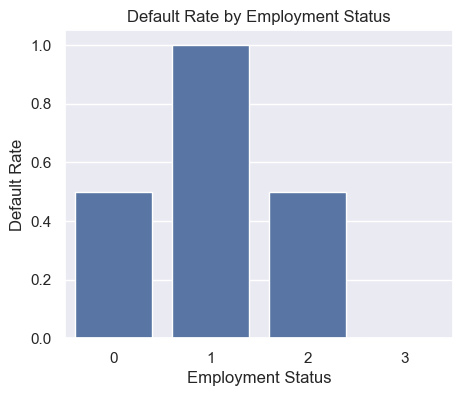

In [143]:
employment_default_rate = cust.groupby('employment_status')['default'].mean().reset_index()

plt.figure(figsize=(5, 4))
sns.barplot(x='employment_status', y='default', data=employment_default_rate)
plt.title('Default Rate by Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Default Rate')
plt.show()


Dari visualisasi ini dapat disimpulkan bahwa jika dilihat dari employment status, orang dg status employed punya kecenderungan lebih tinggi untuk default, dibanding lainnnya. Dan juga student memiliki peluang default rate paling kecil yakni 0%

**Note :** Perlu diingat bahwa jumlah dataset sangatlah sedikit, yang berhasil bayar hanya 3 dari 10, dan kebetulan salah satunya adalah student, dan dia adalah satu satunya student dalam data ini, jadi hasil kesimpulan ini tdk bisa digunakan untuk menyimpulkan secara general

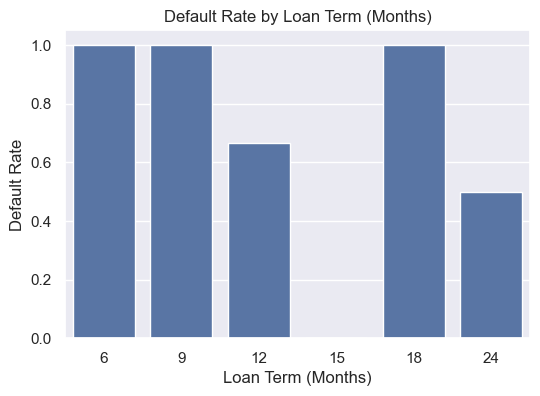

In [144]:
# Group by term_months and calculate default rate
term_default_rate = cust.groupby('term_months')['default'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x='term_months', y='default', data=term_default_rate)
plt.title('Default Rate by Loan Term (Months)')
plt.xlabel('Loan Term (Months)')
plt.ylabel('Default Rate')
plt.show()

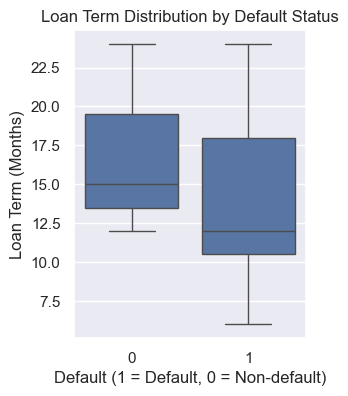

In [145]:
plt.figure(figsize=(3, 4))
sns.boxplot(x='default', y='term_months', data=cust)
plt.title('Loan Term Distribution by Default Status')
plt.xlabel('Default (1 = Default, 0 = Non-default)')
plt.ylabel('Loan Term (Months)')
plt.show()


Loan term yang kurang dari 12 bulan memiliki kecenderungan untuk default dibanding dengan yang diatas 12 bulan

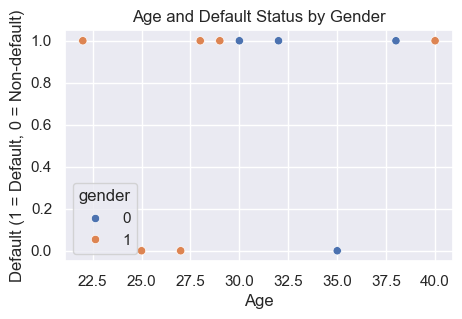

In [146]:
plt.figure(figsize=(5, 3))
sns.scatterplot(x='age', y='default', hue='gender', data=cust)
plt.title('Age and Default Status by Gender')
plt.xlabel('Age')
plt.ylabel('Default (1 = Default, 0 = Non-default)')
plt.show()

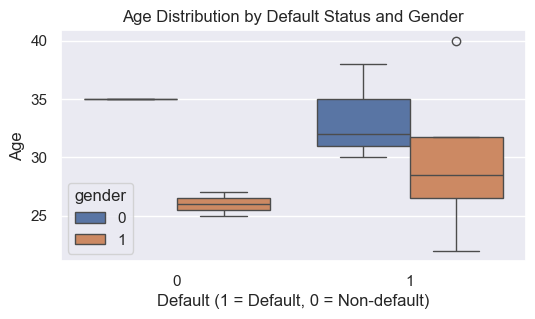

In [147]:
plt.figure(figsize=(6, 3))
sns.boxplot(x='default', y='age', hue='gender', data=cust)
plt.title('Age Distribution by Default Status and Gender')
plt.xlabel('Default (1 = Default, 0 = Non-default)')
plt.ylabel('Age')
plt.show()

Dari hasil visualisasi dapat terlihat bahwa yang cenderung default adalah Male 25-30 dan Female 30-35. Namun age dan gender memiliki korelasi yang sangat kecil sehingga perlu dilakukan validasi untuk melihat pengaruhnya, mengingat data yang ada masih sedikit.

#### Feature Engineering

loan_to_term_ratio: Rasio antara jumlah pinjaman dan jangka waktu.  
interest_to_loan_ratio: Rasio antara bunga dan jumlah pinjaman.  
amount_repaid: Total pembayaran yang telah dilakukan untuk setiap pinjaman.  
repayment_progress: Seberapa banyak pinjaman yang sudah dilunasi.  

In [148]:
cust['loan_to_term'] = cust['loan_amount']/cust['term_months']
cust['interest_to_loan'] = cust['interest_rate']/cust['loan_amount']

paid = repayment.groupby('loan_id').agg({
        'amount_repaid':'sum'
}).reset_index()

paid.columns=['loan_id','Total Paid']

cust = cust.merge(right=paid, how='left')

cust['repayment_progress'] = cust['Total Paid']/cust['loan_amount']
cust = cust.fillna(0)
cust

,loan_id,borrower_id,loan_amount,interest_rate,term_months,status,date_issued,date_due,date_repaid,default,name,age,gender,employment_status,loan_to_term,interest_to_loan,Total Paid,repayment_progress
0,1,101,5000,5.0,12,0,2023-01-01,2023-01-31,0,1,John Doe,28,1,1,416.666667,0.001000,1800.0,0.360000
1,2,102,8000,6.5,24,1,2023-02-01,2023-02-28,2023-03-15 00:00:00,0,Jane Smith,35,0,2,333.333333,0.000812,8000.0,1.000000
2,3,103,3000,4.0,6,0,2023-03-01,2023-03-31,0,1,Bob Johnson,22,1,0,500.000000,0.001333,0.0,0.000000
3,4,104,7000,7.5,18,0,2023-04-01,2023-04-30,0,1,Alice Brown,30,0,1,388.888889,0.001071,2000.0,0.285714
4,5,105,6000,6.0,12,1,2023-05-01,2023-05-31,2023-06-10 00:00:00,0,Charlie Lee,25,1,3,500.000000,0.001000,6000.0,1.000000
5,6,106,4500,4.5,9,0,2023-06-01,2023-06-30,0,1,David White,40,1,2,500.000000,0.001000,4500.0,1.000000
6,7,107,9000,8.0,24,0,2023-07-01,2023-07-31,0,1,Eva Green,32,0,1,375.000000,0.000889,9000.0,1.000000
7,8,108,5500,5.5,15,1,2023-08-01,2023-08-31,2023-09-10 00:00:00,0,Frank Miller,27,1,0,366.666667,0.001000,5500.0,1.000000
8,9,109,4000,4.0,12,0,2023-09-01,2023-09-30,0,1,Gina Davis,38,0,1,333.333333,0.001000,4000.0,1.000000
9,10,110,7500,7.0,18,0,2023-10-01,2023-10-31,0,1,Harry Black,29,1,1,416.666667,0.000933,7500.0,1.000000


Ketika data telah dijoin antara loan dan repayment, ada beberapa loan_id **(6,7,9,10)** yang sebenarnya total paid sudah lunas semua, tapi kenapa di tabel loan statusnya masih approve? bukankah seharusnya statusnya sudah repaid? dan date repaid harusnya sudah keluar di tabel loan

In [149]:
cust[['loan_to_term', 'interest_to_loan', 'Total Paid', 'default']].corr()['default']

loan_to_term        0.135819
interest_to_loan    0.335612
Total Paid         -0.392206
default             1.000000
Name: default, dtype: float64

Dari fitur baru yang telah dibuat dapat disimpulkan korelasinya

**Interest-to-Loan Ratio (0.335612):**

Korelasi positif sedang, artinya semakin tinggi bunga relatif terhadap jumlah pinjaman, semakin besar kemungkinan default. Ini masuk akal karena beban bunga yang lebih tinggi bisa menjadi sulit bagi peminjam untuk melunasi.

**Total Paid (-0.392206):**

Korelasi negatif yang sedang kuat menunjukkan bahwa semakin banyak jumlah pembayaran yang telah dilakukan, semakin kecil kemungkinan default. Artinya, peminjam yang telah membayar lebih banyak cenderung lebih sedikit risiko gagal bayar.

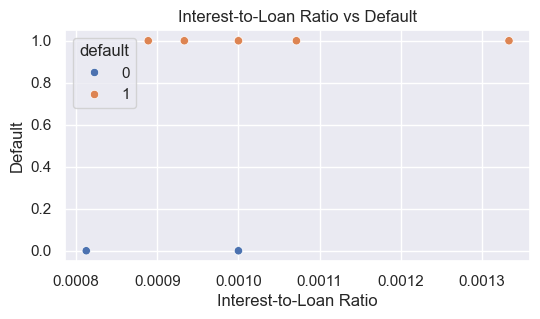

In [150]:
plt.figure(figsize=(6, 3))
sns.scatterplot(x=cust['interest_to_loan'], y=cust['default'], hue=cust['default'])

# Menambahkan judul dan label
plt.title('Interest-to-Loan Ratio vs Default')
plt.xlabel('Interest-to-Loan Ratio')
plt.ylabel('Default')

# Menampilkan plot
plt.show()

#### Kesimpulan

dari hasil analisis korelasi dan melihat distirbusi data dapat disimpulkan bahwa untuk mengurangi resiko default sebaiknya
- semakin lama jangka waktu pinjaman (lebih dari 12 bulan), kemungkinan gagal bayar sedikit lebih kecil. (korelasi -0.230022)
- employment student lebih cenderung minim resiko default (korelasi -0.350438)
- kurangi customer dg demografi Male 25-30 dan Female 30-35 karena cenderung meningkatkan default namun korelasinya kecil (Age 0.193706, Gender -0.089087)
- Rasio bunga terhadap pinjaman sebaiknya jangan terlalu tinggi untuk mengurangi risiko default

Note : Dataset ini hanya berisi 10 row setiap tabelnya sehingga sangat kurang untuk dijadikan kesimpulan secara general
dan ada keanehan pada data dimana loan_id **(6,7,9,10)** yang sebenarnya total paid sudah lunas semua, tapi kenapa di tabel loan statusnya masih approve